In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
#Act = pd.read_csv("atusact_0323.dat")
Resp=pd.read_csv("atusresp_0323.dat")
Raster=pd.read_csv("atusrost_0323.dat")

In [47]:
# vars interested in 
respondent_vars = ['TUCASEID', 'TRTALONE', 'TRNUMHOU', 'TRSPPRES', 'TELFS', 'TRTSPONLY', 'TRTFAMILY']
roster_vars = ['TUCASEID', 'TEAGE', 'TESEX'] 

Dependent:
TRTALONE: Total time (in minutes) the respondent spent alone, excluding sleep.

Predictors used:

TUCASEID: Unique identifier for each household.
TRNUMHOU: Number of people living in the respondents household.
TELFS: Labor force status of the respondent.
1 Employed - at work
2 Employed - absent
3 Unemployed - on layoff
4 Unemployed - looking
5 Not in labor force
TEHRUSL1: Average number of hours per week the respondent usually works at their 
main job.

TRSPPRES: Presence of the respondents spouse or unmarried partner in the household, coded as follows:
1: Spouse present
2:Unmarried partner present
3:No spouse or partner present
TRTFAMILY: Total time (in minutes) the respondent spent with family members, excluding work-related activities.
TRTSPONLY: Total time (in minutes) the respondent spent exclusively with their spouse, excluding work-related activities.
TESEX: Sex of the respondent.
TEAGE: Age of the respondent. 
TEIO1OCD (occupation code for the respondent's main job)



In [48]:
# Subset the data to the variables of interest
respondent_subset = Resp[respondent_vars]
roster_subset = Raster[roster_vars]
# Merge the files on the ID column
merged_df = pd.merge(respondent_subset, roster_subset, on='TUCASEID', how='inner')
# I am investigating only for the adults 
adults_df = merged_df[merged_df['TEAGE'] >18]

#take a random sample as the data is huge 
sampled_df = adults_df.sample(n=1000, random_state=42)  # random_state for reproducibility

final_df = sampled_df.drop_duplicates(subset='TUCASEID')


In [49]:
# Add a year col
final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)

/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_14122/181919075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)


In [53]:
data=final_df

Data Exploration 

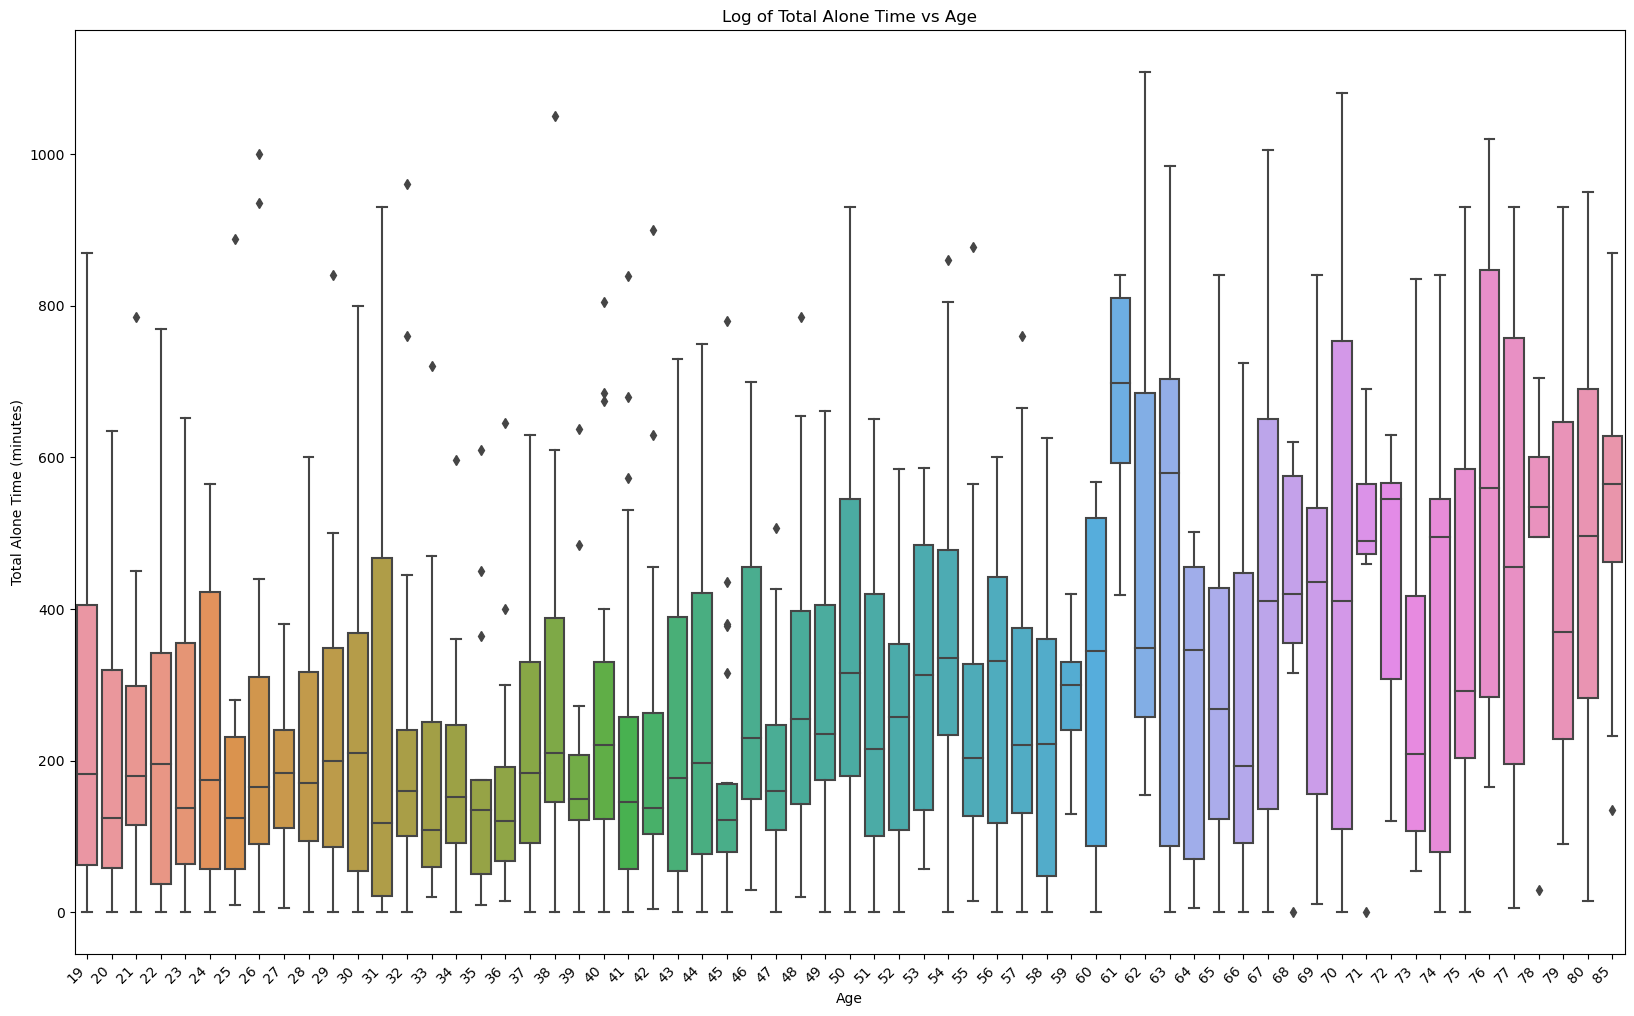

In [8]:
# Distribtuion of Total Alone Time by Age 

plt.figure(figsize=(20, 12))

sns.boxplot(data=final_df, x='TEAGE', y='TRTALONE')
plt.title('Log of Total Alone Time vs Age')
plt.xlabel('Age')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()



/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_14122/1361461877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Age Group'] = pd.cut(final_df['TEAGE'], bins=age_bins, labels=age_labels, right=False)


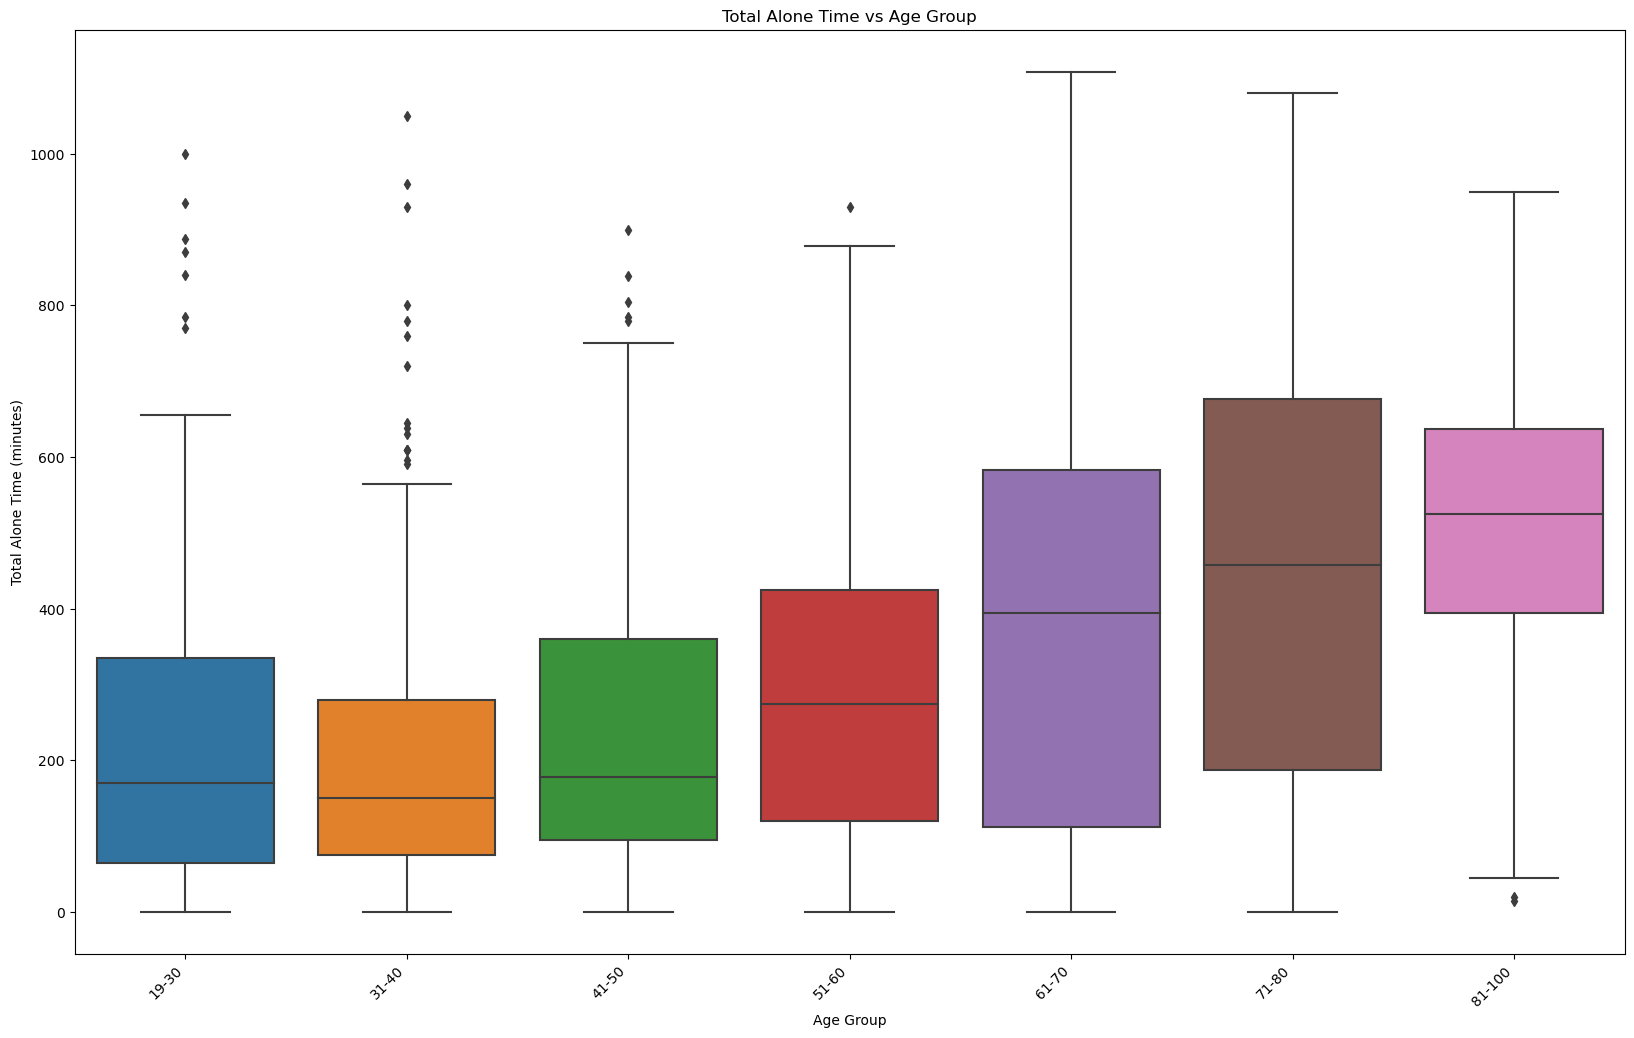

In [80]:
# Grouping ages into bins
age_bins = [19, 30, 40, 50, 60, 70, 80, 100]
age_labels = ['19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-100']

# Add a new column for age categories
final_df['Age Group'] = pd.cut(final_df['TEAGE'], bins=age_bins, labels=age_labels, right=False)

plt.figure(figsize=(20, 12))
sns.boxplot(data=final_df, x='Age Group', y='TRTALONE')
plt.title('Total Alone Time vs Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks(rotation=45, ha='right')
plt.show()



In [20]:
final_df.columns.unique()

Index(['TUCASEID', 'TRTALONE', 'TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1',
       'TRTSPONLY', 'TRTFAMILY', 'TEIO1OCD', 'TEAGE', 'TESEX', 'Age Group'],
      dtype='object')

In [31]:
data.rename(columns={'TRNUMHOU':'HH_size', 'TEAGE':'Age', 'TESEX':'Sex', 'TELFS':'Labour_Status', 
                    'TRSPPRES':'Spouse_Partner_Presence', 'TRTSPONLY':'TimewithSpouse/Partener(Minutes)', 'TRTFAMILY':
                     'TimewithFamily(Minutes)'}, inplace=True)

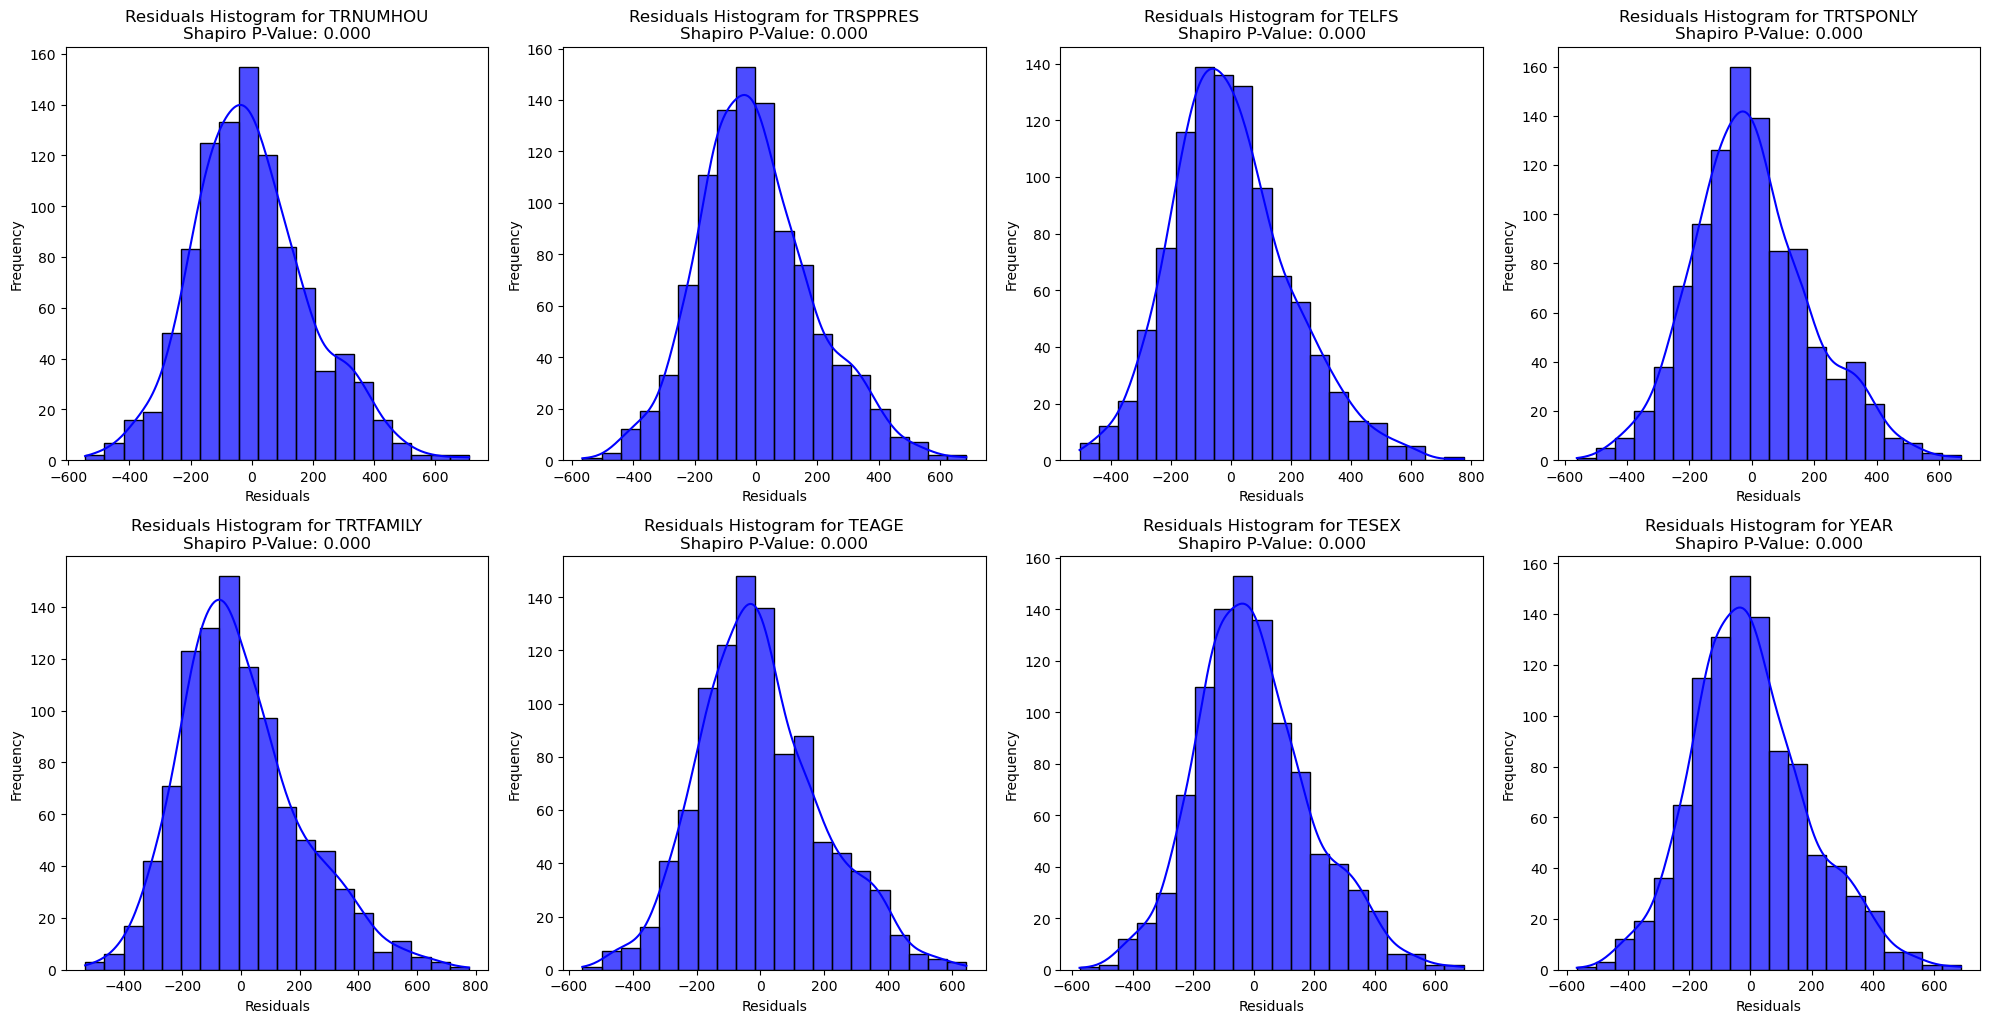

Shapiro-Wilk Test Results:
   Predictor  Shapiro-Wilk P-Value
0   TRNUMHOU          2.148435e-07
1   TRSPPRES          1.035513e-07
2      TELFS          2.210700e-08
3  TRTSPONLY          4.338460e-07
4  TRTFAMILY          8.440485e-13
5      TEAGE          1.337654e-07
6      TESEX          1.349631e-07
7       YEAR          1.215887e-07


In [65]:
from scipy.stats import shapiro
# Prepare a dataframe to store Shapiro test results
shapiro_results = []

# Set up the plotting grid
plt.figure(figsize=(20, 15))

# Loop through each predictor
for i, predictor in enumerate(predictor_cols, 1):
    # Define predictors excluding the current one
    predictors_excluding = [col for col in predictor_cols if col != predictor]
    
    # Fit the linear regression model excluding the current predictor
    X_excluding = data[predictors_excluding]
    X_excluding = sm.add_constant(X_excluding)  # Add intercept
    model_excluding = sm.OLS(y, X_excluding).fit()
    
    # Calculate residuals for the reduced model
    residuals_excluding = model_excluding.resid
    
    # Perform Shapiro-Wilk test
    shapiro_stat, shapiro_p = shapiro(residuals_excluding)
    shapiro_results.append({'Predictor': predictor, 'Shapiro-Wilk P-Value': shapiro_p})
    
    # Plot histogram of residuals
    plt.subplot(3, 4, i)  # Adjust layout for 10 plots
    sns.histplot(residuals_excluding, bins=20, kde=True, color='blue', alpha=0.7)
    plt.title(f'Residuals Histogram for {predictor}\nShapiro P-Value: {shapiro_p:.3f}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Convert Shapiro test results to a DataFrame
shapiro_results_df = pd.DataFrame(shapiro_results)

shapiro_results_df


In [68]:
shapiro_results_df

,Predictor,Shapiro-Wilk P-Value
0,TRNUMHOU,2.148435e-07
1,TRSPPRES,1.035513e-07
2,TELFS,2.210700e-08
3,TRTSPONLY,4.338460e-07
4,TRTFAMILY,8.440485e-13
5,TEAGE,1.337654e-07
6,TESEX,1.349631e-07
7,YEAR,1.215887e-07


In [66]:
from scipy.stats import levene

# Prepare a list to store Levene's test results
levene_results = []

# Loop through each predictor
for predictor in predictor_cols:
    # Check if the predictor is categorical or continuous
    if data[predictor].nunique() < 10:  # Categorical variable
        # Group residuals by the predictor categories
        groups = [residuals[data[predictor] == level] for level in data[predictor].unique()]
    else:  # Continuous variable
        # Bin continuous variable into quartiles for grouping
        bins = pd.qcut(data[predictor], q=4, duplicates='drop')  # Bin into quartiles
        groups = [residuals[bins == level] for level in bins.unique()]
    
    # Perform Levene's Test for equal variance
    levene_stat, levene_p = levene(*groups, center='median')  # Median for robustness
    
    # Store the result
    levene_results.append({'Predictor': predictor, 'Levene Statistic': levene_stat, 'Levene P-Value': levene_p})

# Convert the results into a DataFrame
levene_results_df = pd.DataFrame(levene_results)

# Display the results
print("Levene's Test Results:")
print(levene_results_df)


Levene's Test Results:
   Predictor  Levene Statistic  Levene P-Value
0   TRNUMHOU          8.333321    1.780966e-05
1   TRSPPRES         16.979487    5.608253e-08
2      TELFS          1.366243    2.436706e-01
3  TRTSPONLY          9.780898    1.814467e-03
4  TRTFAMILY         45.058240    2.631951e-27
5      TEAGE          5.382731    1.119837e-03
6      TESEX          0.071860    7.887031e-01
7       YEAR          0.811465    4.875870e-01


In [67]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import levene

# Apply log transformation to predictors that violated equal variance
data['TRNUMHOU_log'] = np.log1p(data['TRNUMHOU'])
data['TRSPPRES_log'] = np.log1p(data['TRSPPRES'])
data['TRTSPONLY_log'] = np.log1p(data['TRTSPONLY'])
data['TRTFAMILY_log'] = np.log1p(data['TRTFAMILY'])
data['TEAGE_log'] = np.log1p(data['TEAGE'])

# Update predictors list with log-transformed columns
log_transformed_predictors = [
    'TRNUMHOU_log', 
    'TRSPPRES_log', 
    'TRTSPONLY_log', 
    'TRTFAMILY_log', 
    'TEAGE_log', 
    'TELFS', 
    'TESEX', 
    'YEAR'
]

# Define predictors and target variable
X_log_transformed = data[log_transformed_predictors]
y = data['TRTALONE']

# Add constant to predictors
X_log_transformed = sm.add_constant(X_log_transformed)

# Fit linear regression with transformed predictors
model_log_transformed = sm.OLS(y, X_log_transformed).fit()

# Print summary
print(model_log_transformed.summary())

# Recheck for equal variance using Levene's test
levene_results = []
for predictor in log_transformed_predictors:
    stat, p_value = levene(y, data[predictor])
    levene_results.append({'Predictor': predictor, 'Levene Statistic': stat, 'Levene P-Value': p_value})

# Convert results to a DataFrame for readability
levene_df = pd.DataFrame(levene_results)

# Display results
print(levene_df)


                            OLS Regression Results                            
Dep. Variable:               TRTALONE   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     56.25
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           1.79e-75
Time:                        00:30:53   Log-Likelihood:                -6718.7
No. Observations:                 999   AIC:                         1.346e+04
Df Residuals:                     990   BIC:                         1.350e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -491.9072   2135.491     -0.230

/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_14122/1891639586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TRNUMHOU_log'] = np.log1p(data['TRNUMHOU'])
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_14122/1891639586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TRSPPRES_log'] = np.log1p(data['TRSPPRES'])
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_14122/1891639586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [69]:
levene_results_df

,Predictor,Levene Statistic,Levene P-Value
0,TRNUMHOU,8.333321,1.780966e-05
1,TRSPPRES,16.979487,5.608253e-08
2,TELFS,1.366243,2.436706e-01
3,TRTSPONLY,9.780898,1.814467e-03
4,TRTFAMILY,45.058240,2.631951e-27
5,TEAGE,5.382731,1.119837e-03
6,TESEX,0.071860,7.887031e-01
7,YEAR,0.811465,4.875870e-01


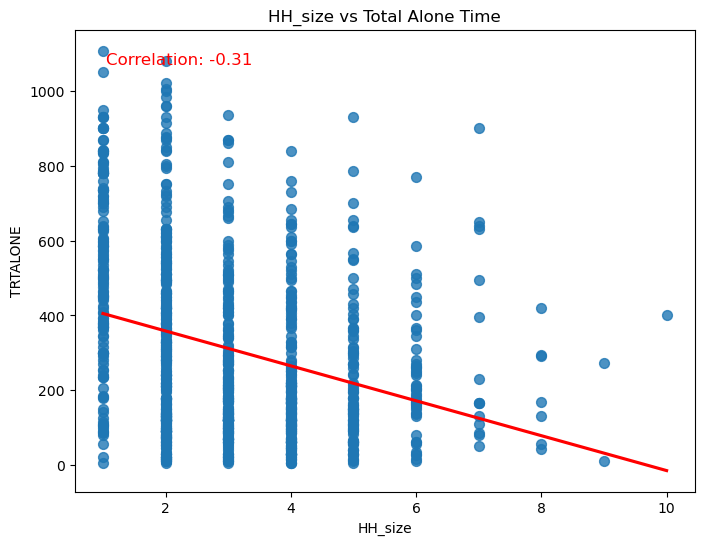

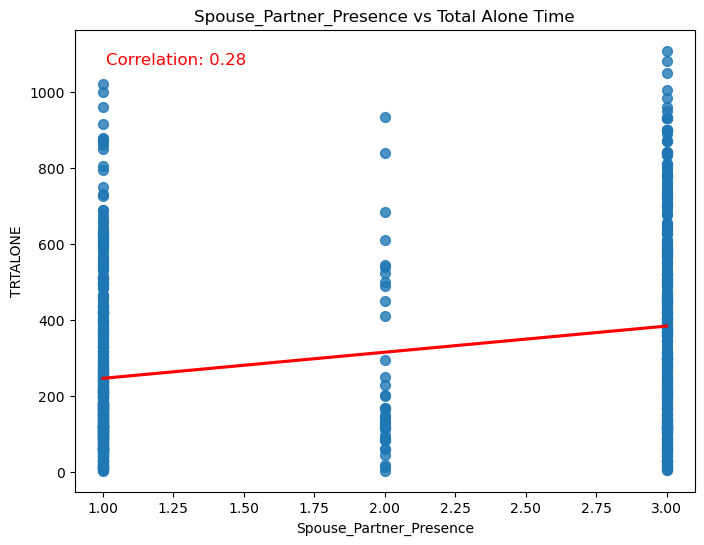

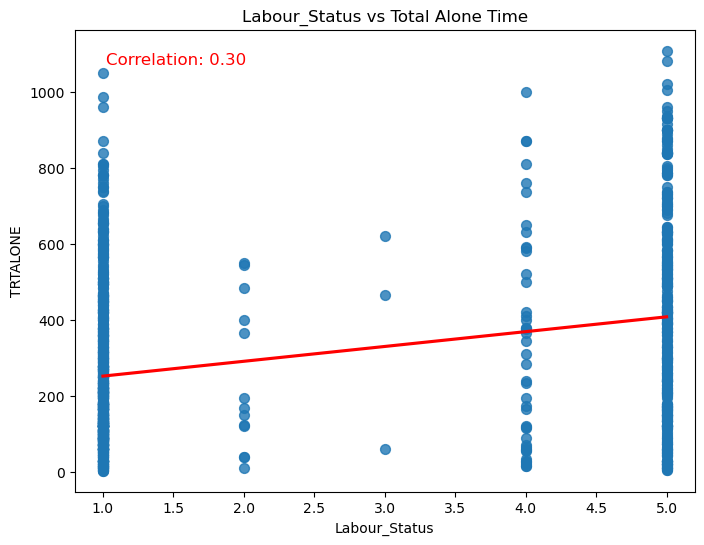

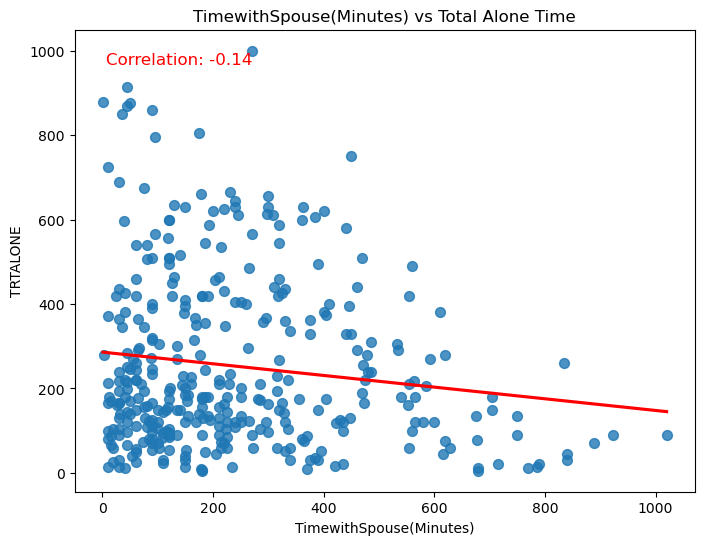

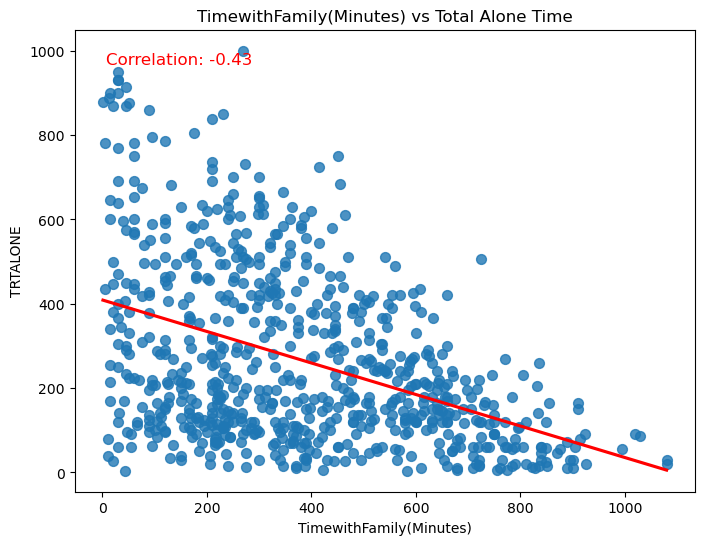

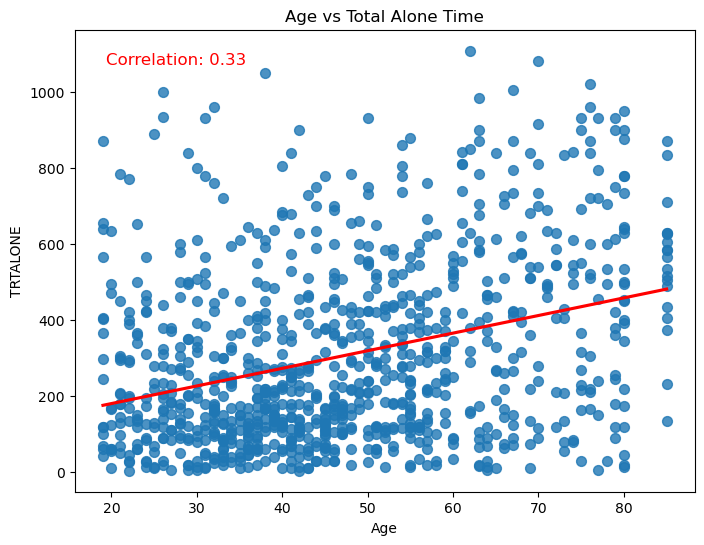

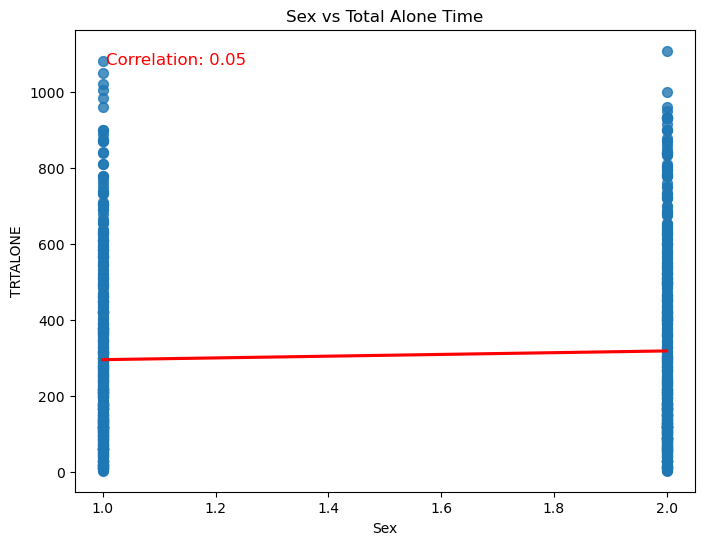

In [33]:
coltoplot = ['HH_size', 'Spouse_Partner_Presence',
       'Labour_Status', 'TimewithSpouse(Minutes)',
       'TimewithFamily(Minutes)', 'Age', 'Sex']

# Loop over each column in coltoplot
for col in coltoplot:
    # Filter out non-positive values in both the column and the '5Yr_Average' column
    filtered_data = data[(data[col] > 0) & (data['TRTALONE'] > 0)]
    
    # Create scatter plot with a line of best fit
    plt.figure(figsize=(8, 6))  # Optional: Set figure size for better readability
    sns.regplot(data=filtered_data, x=col, y='TRTALONE', scatter_kws={'s': 50}, line_kws={'color': 'red'}, ci=None)  # Red line for regression line
    
    # Calculate the correlation coefficient
    correlation = np.corrcoef(filtered_data[col].dropna(), filtered_data['TRTALONE'].dropna())[0, 1]
    
    # Add title and correlation coefficient to the plot
    plt.title(f'{col} vs Total Alone Time')
    
    # Display the correlation on the plot
    plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top', horizontalalignment='left', color='red')
    
    # Display the plot
    plt.show()

In [52]:
# List of columns to calculate correlation with 'TRTALONE'
coltoplot = ['HH_size', 'Spouse_Partner_Presence', 'Labour_Status', 
             'TimewithSpouse(Minutes)', 'TimewithFamily(Minutes)', 
             'Age', 'Sex', 'Year'] 

# Calculate Pearson correlation with Total Alone Time
correlations = data[coltoplot].corrwith(data['TRTALONE'])

# Create a DataFrame to display the results
correlation_df = pd.DataFrame(correlations, columns=['Pearson Correlation'])
correlation_df = correlation_df.reset_index().rename(columns={'index': 'Variable'})

correlation_df


KeyError: "['Year'] not in index"

In [34]:
# Example: Scatter plot with categorical variable as color
sns.scatterplot(data=data, x='TRTALONE', y='Sex', hue='categorical_variable', palette='Set1')

plt.title('Scatter Plot: Continuous vs Categorical')
plt.xlabel('Continuous Variable')
plt.ylabel('Categorical Variable')
plt.show()


ValueError: Could not interpret value `categorical_variable` for parameter `hue`

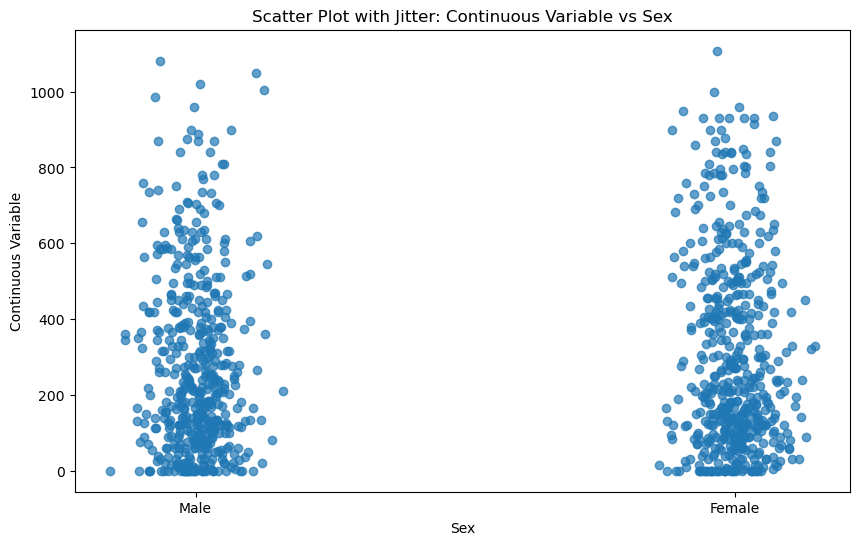

In [36]:

# Add jitter to the categorical variable (Sex)
jittered_x = data['Sex'].apply(lambda x: np.random.normal(loc=x, scale=0.05))

plt.figure(figsize=(10, 6))
plt.scatter(jittered_x, data['TRTALONE'], alpha=0.7)
plt.title('Scatter Plot with Jitter: Continuous Variable vs Sex')
plt.xlabel('Sex')
plt.ylabel('Continuous Variable')
plt.xticks([1, 2], ['Male', 'Female'])
plt.show()


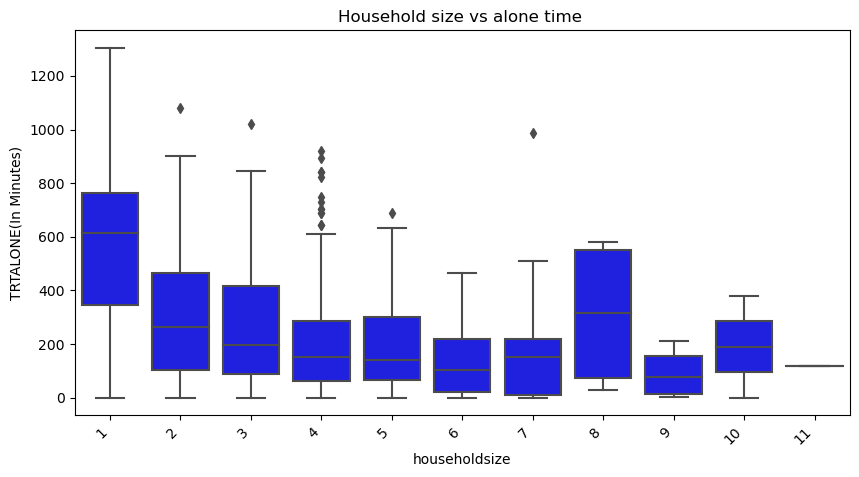

In [88]:
# Number of people living in the respondents household vs alone time 

plt.figure(figsize=(10, 5))

sns.boxplot(data=final_df, x='TRNUMHOU', y='TRTALONE', color='blue')

plt.title('Household size vs alone time ')
plt.xlabel('householdsize')
plt.ylabel('TRTALONE(In Minutes)')
plt.xticks(rotation=45, ha='right')

plt.show()

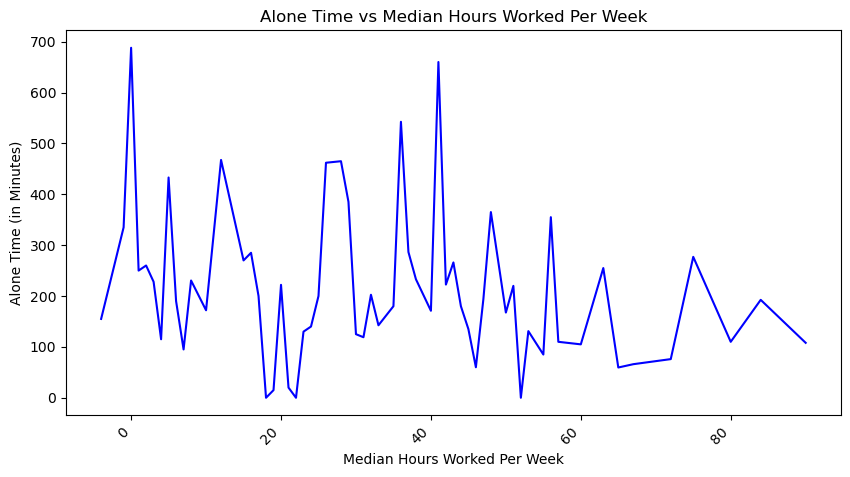

In [122]:
#Average Number of Hours Per Week the Respondent Usually Works at Their Main Job vs Alone Time

plt.figure(figsize=(10, 5))
sns.lineplot(data=median_df, x='TEHRUSL1', y='TRTALONE', color='blue', estimator='median')

# Title and labels
plt.title('Alone Time vs Median Hours Worked Per Week')
plt.xlabel('Median Hours Worked Per Week')
plt.ylabel('Alone Time (in Minutes)')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


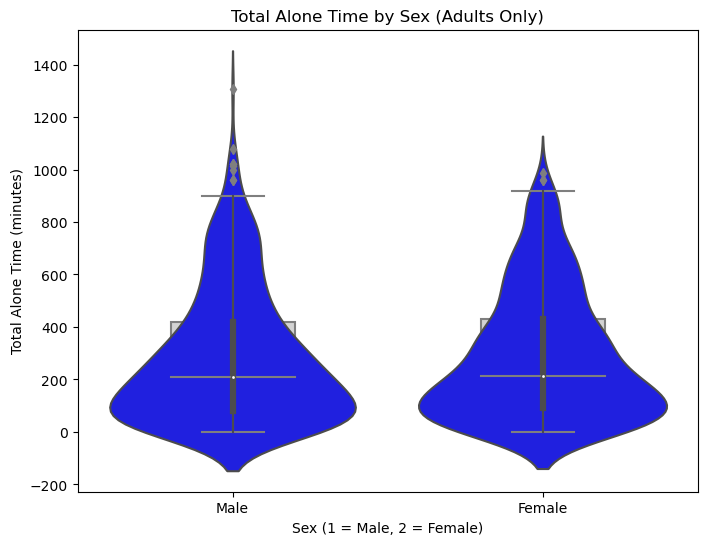

In [14]:
# boxplot for TRTALONE by TESEX
plt.figure(figsize=(8, 6))

sns.boxplot(data=final_df, x='TESEX', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TESEX', y='TRTALONE', color='blue', alpha=0.5)

plt.title('Total Alone Time by Sex (Adults Only)')
plt.xlabel('Sex (1 = Male, 2 = Female)')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1], ['Male', 'Female'])  

plt.show()

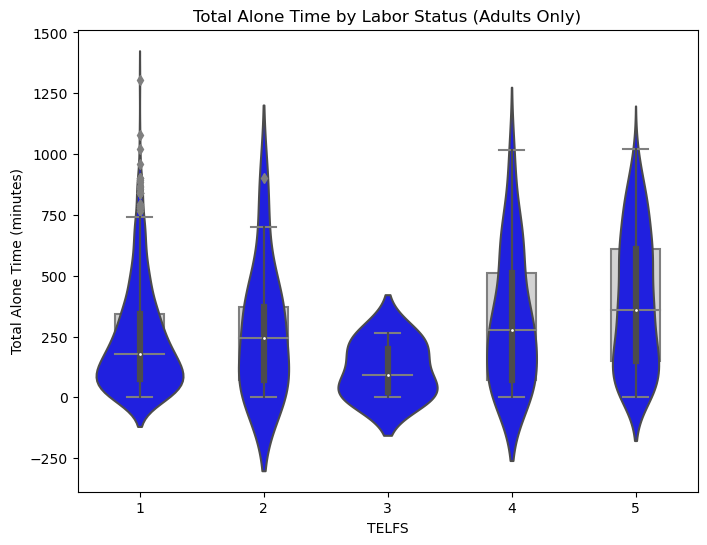

In [15]:
# boxplot for Total Alone Time by Labor Status (Adults Only)'
plt.figure(figsize=(8, 6))

# Create a boxplot
sns.boxplot(data=final_df, x='TELFS', y='TRTALONE', color='lightgray', width=0.4)

# Overlay a violin plot
sns.violinplot(data=final_df, x='TELFS', y='TRTALONE', color='blue', alpha=0.5)

# Customizing the plot
plt.title('Total Alone Time by Labor Status (Adults Only)')
plt.ylabel('Total Alone Time (minutes)')  # Setting labels for clarity

plt.show()

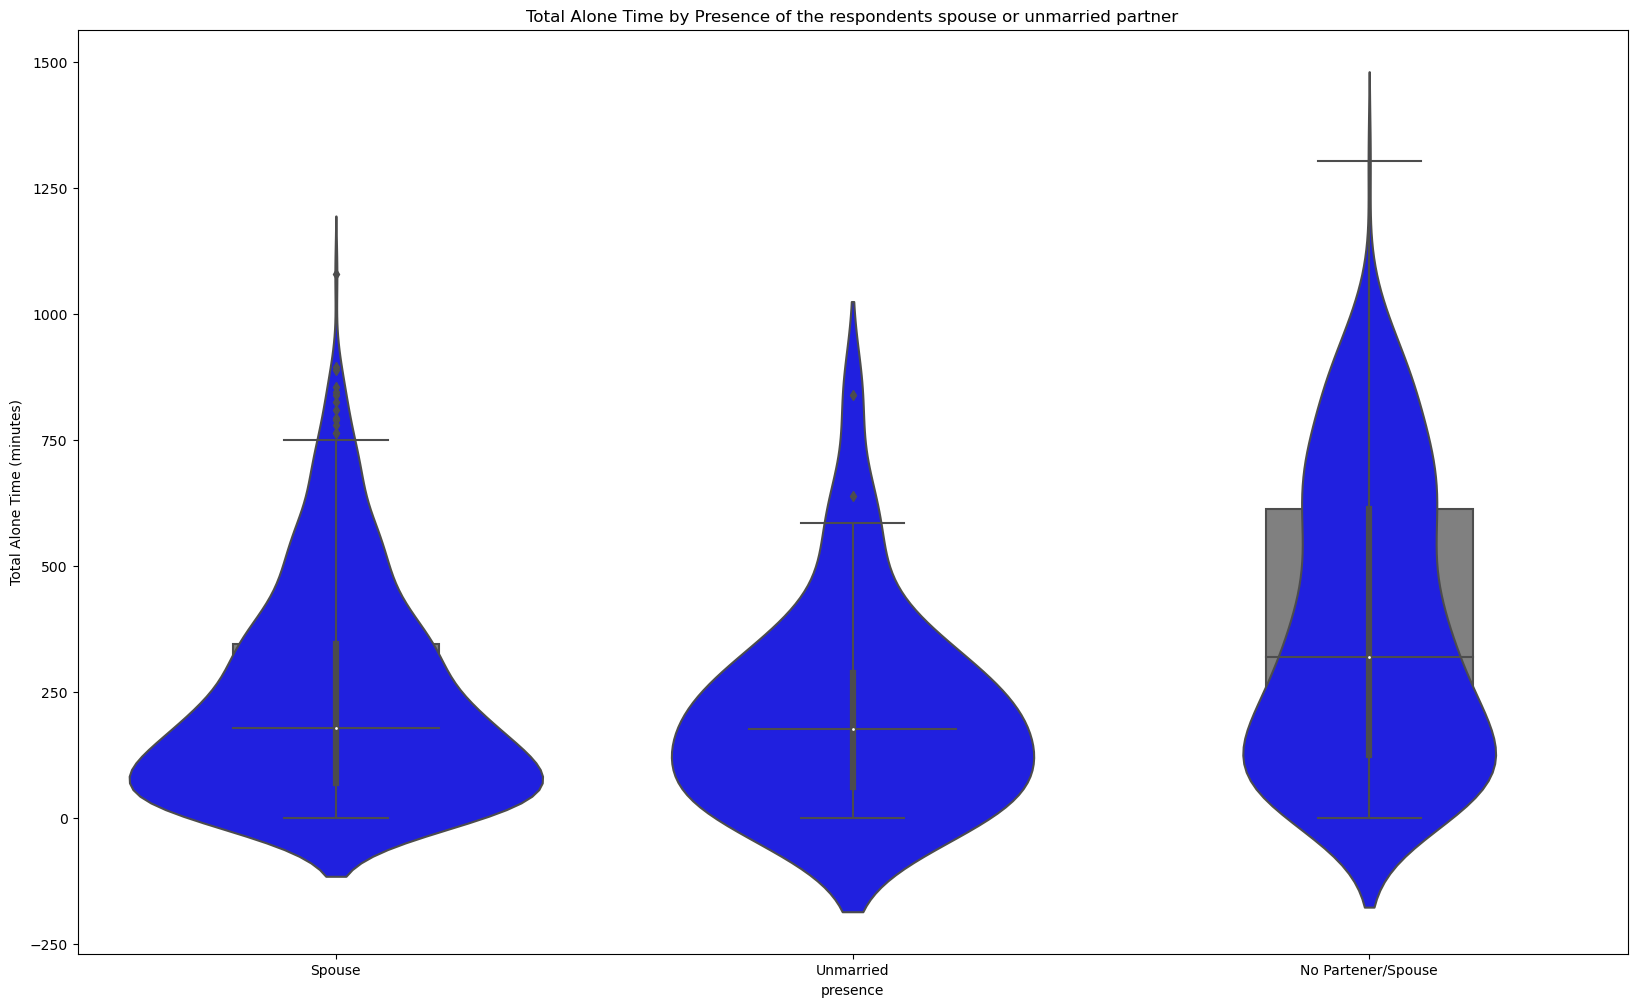

In [137]:
# boxplot for Total Alone Time by Presence of the respondents spouse or unmarried partner
plt.figure(figsize=(20, 12))

sns.boxplot(data=final_df, x='TRSPPRES', y='TRTALONE', color='gray', width=0.4)

# violin plot
sns.violinplot(data=final_df, x='TRSPPRES', y='TRTALONE', color='blue', alpha=0.5)

plt.title('Total Alone Time by Presence of the respondents spouse or unmarried partner')
plt.xlabel('presence')
plt.ylabel('Total Alone Time (minutes)')
plt.xticks([0, 1, 2], ['Spouse', 'Unmarried', 'No Partener/Spouse'])  

plt.show()

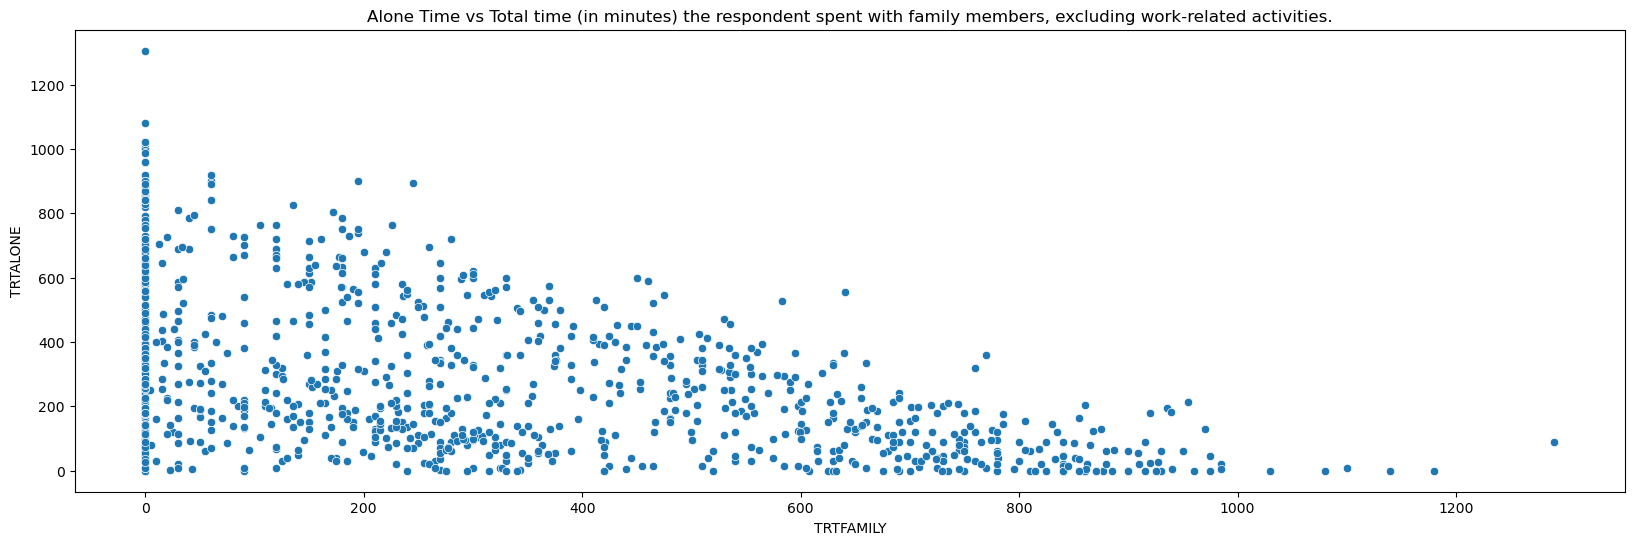

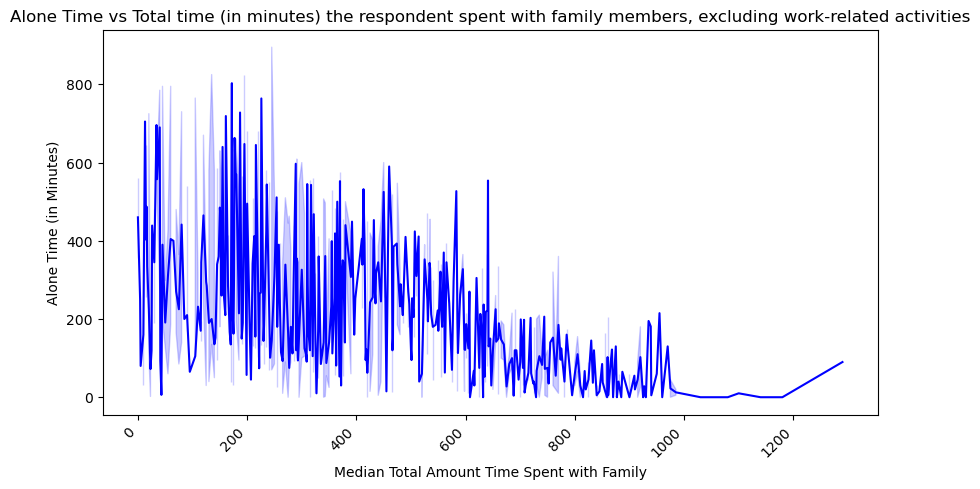

In [8]:
plt.figure(figsize=(20,6))

sns.scatterplot(data=final_df, x='TRTFAMILY', y='TRTALONE')
plt.title('Alone Time vs Total time (in minutes) the respondent spent with family members, excluding work-related activities.')

plt.show()


#

plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='TRTFAMILY', y='TRTALONE', color='blue', estimator='median')

# Title and labels
plt.title('Alone Time vs Total time (in minutes) the respondent spent with family members, excluding work-related activities')
plt.xlabel('Median Total Amount Time Spent with Family')
plt.ylabel('Alone Time (in Minutes)')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

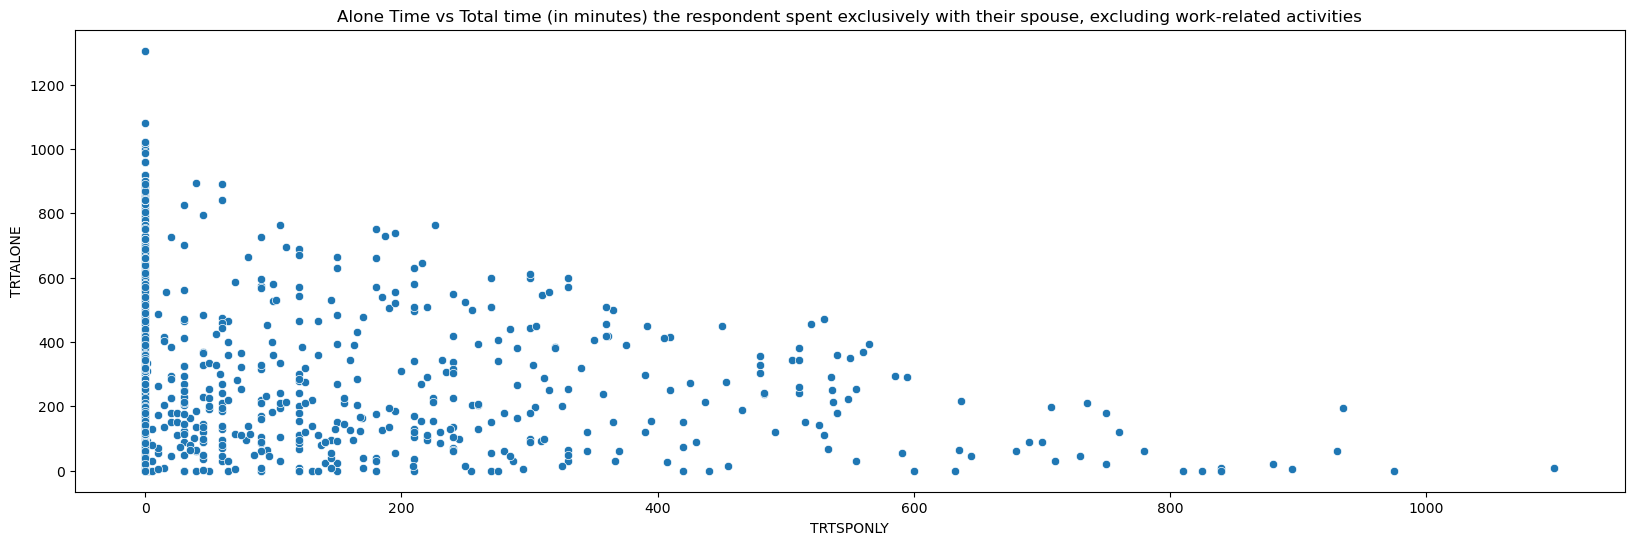

In [152]:
plt.figure(figsize=(20,6))

sns.scatterplot(data=final_df, x='TRTSPONLY', y='TRTALONE')
plt.title('Alone Time vs Total time (in minutes) the respondent spent exclusively with their spouse, excluding work-related activities')

plt.show()

In [9]:
# I am creating the YEAR column by extracting the first four digits of the TUCASEID as they correspond to the year 
final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)


/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_95045/2335185010.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['YEAR'] = final_df['TUCASEID'].astype(str).str[:4].astype(int)


In [12]:
# List of the predictor columns 

predictor_cols = ['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TEHRUSL1', 'TRTSPONLY', 'TRTFAMILY', 'TEAGE', 'TESEX', 'YEAR']

#  Df to store summary statistics
summary_stats = pd.DataFrame(columns=['Predictor', 'Mean', 'Median', 'Standard Deviation'])

# Calculate descriptive statistics for each predictor
for predictor in predictor_cols:
    stats = final_df.groupby(predictor)['TRTALONE'].agg(['mean', 'median', 'std']).reset_index()
    
    # Store the overall statistics in a new row for summary
    overall_stats = {
        'Predictor': predictor,
        'Mean': stats['mean'].mean(),
        'Median': stats['median'].median(),
        'Standard Deviation': stats['std'].mean() 
         
    }
    
    summary_stats = summary_stats.append(overall_stats, ignore_index=True)



/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_95045/572535912.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_95045/572535912.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_95045/572535912.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary_stats = summary_stats.append(overall_stats, ignore_index=True)
/var/folders/2x/vtjgswgj6pj1xwzfpdt05jt40000gp/T/ipykernel_95045/572535912.py:21: FutureWarning: The frame.append method is deprecated a

In [13]:
summary_stats

,Predictor,Mean,Median,Standard Deviation
0,TRNUMHOU,236.526047,153.00,214.183429
1,TRSPPRES,272.968905,180.00,228.850989
2,TELFS,266.299871,242.50,228.217393
3,TEHRUSL1,240.880685,191.25,197.419414
4,TRTSPONLY,221.076721,206.00,165.051882
5,TRTFAMILY,219.696311,176.00,141.474225
6,TEAGE,307.732405,231.00,233.691162
7,TESEX,285.312748,212.00,248.624098
8,YEAR,289.190644,219.00,247.249916


In [70]:
#check for the correlation between the predictors 
# Select only the predictor columns
predictor_cols = ['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TRTSPONLY', 'TRTFAMILY', 'TEAGE', 'TESEX', 'YEAR']

# Calculate the correlation matrix for the predictor variables
correlation_matrix = data[predictor_cols].corr()

 

In [71]:
correlation_matrix

,TRNUMHOU,TRSPPRES,TELFS,TRTSPONLY,TRTFAMILY,TEAGE,TESEX,YEAR
TRNUMHOU,1.000000,-0.155482,-0.107176,-0.165310,0.258767,-0.359513,-0.004670,-0.039892
TRSPPRES,-0.155482,1.000000,0.123856,-0.482225,-0.436522,0.015032,0.055313,0.069715
TELFS,-0.107176,0.123856,1.000000,0.086999,0.069748,0.381749,0.049008,0.098304
TRTSPONLY,-0.165310,-0.482225,0.086999,1.000000,0.465987,0.229591,-0.022059,0.050132
TRTFAMILY,0.258767,-0.436522,0.069748,0.465987,1.000000,-0.087365,0.019083,-0.011555
TEAGE,-0.359513,0.015032,0.381749,0.229591,-0.087365,1.000000,0.037010,0.104245
TESEX,-0.004670,0.055313,0.049008,-0.022059,0.019083,0.037010,1.000000,-0.013254
YEAR,-0.039892,0.069715,0.098304,0.050132,-0.011555,0.104245,-0.013254,1.000000


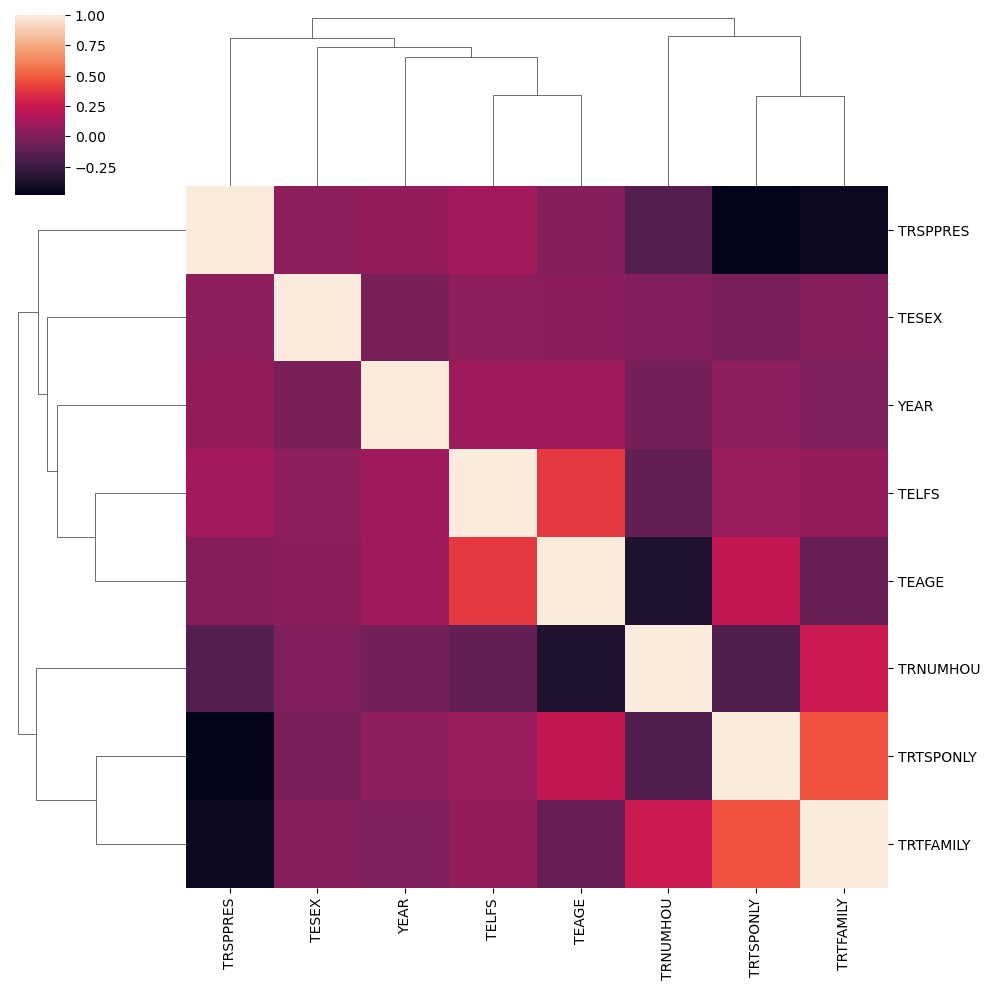

In [72]:
sns.clustermap(correlation_matrix )

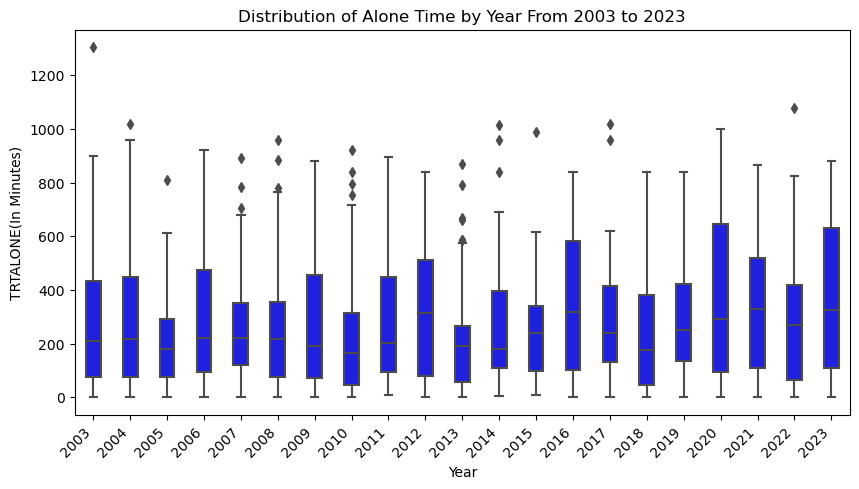

In [61]:
# boxplot of 'TRTALONE' values grouped by 'YEAR'
plt.figure(figsize=(10, 5))


sns.boxplot(data=final_df, x='YEAR', y='TRTALONE', color='blue', width=0.4)

#final_df.boxplot(column='TRTALONE', by='YEAR', grid=True)

plt.title('Distribution of Alone Time by Year From 2003 to 2023')
plt.xlabel('Year')
plt.ylabel('TRTALONE(In Minutes)')
plt.xticks(rotation=45, ha='right')

plt.show()


In [158]:
final_df.to_csv('final_df.csv')

Models 

In [17]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro



In [29]:
#Check model assumptions for linear regression for each predictor.
    
   
def check_assumptions_per_predictor(data, target, predictors):
    
    results = {}
    
    for predictor in predictors:
        # Prepare data
        X = data[[predictor]]
        X = sm.add_constant(X)  # Add intercept
        y = data[target]
        
        # Fit the model
        model = sm.OLS(y, X).fit()
        residuals = model.resid
        fitted = model.fittedvalues
        
        # Assumption 1: Linearity (Correlation between predictor and target)
        correlation = np.corrcoef(data[predictor], y)[0, 1]
        
        # Assumption 2: Homoscedasticity (Breusch-Pagan Test)
        bp_test = het_breuschpagan(residuals, X)
        bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
        bp_results = dict(zip(bp_labels, bp_test))
        
        # Assumption 3: Normality of Residuals (Shapiro-Wilk Test)
        shapiro_test = shapiro(residuals)
        normality_results = {
            "Shapiro-Wilk Statistic": shapiro_test.statistic,
            "p-value": shapiro_test.pvalue
        }
        
        # Store results for the predictor
        results[predictor] = {
            "Linearity (Correlation Coefficient)": correlation,
            "Homoscedasticity (Breusch-Pagan Test)": bp_results,
            "Normality of Residuals (Shapiro-Wilk Test)": normality_results
        }
    
    return results


In [31]:
# cHECK FOR ASSUMPTIONS
predictors = ['TRNUMHOU', 'TELFS', 'TRSPPRES', 'TRTFAMILY', 'TRTSPONLY', 'TESEX', 'TEAGE', 'TEIO1OCD', 'YEAR']
results_per_predictor = check_assumptions_per_predictor(final_df, target='TRTALONE', predictors=predictors)

# Display results
for predictor, results in results_per_predictor.items():
    print(f"Predictor: {predictor}")
    for assumption, value in results.items():
        print(f"  {assumption}: {value}")
    print("\n")


Predictor: TRNUMHOU
  Linearity (Correlation Coefficient): -0.3602689285568482
  Homoscedasticity (Breusch-Pagan Test): {'Lagrange multiplier statistic': 31.66520599295493, 'p-value': 1.8317471931491945e-08, 'f-value': 32.637286129586656, 'f p-value': 1.4659729627396232e-08}
  Normality of Residuals (Shapiro-Wilk Test): {'Shapiro-Wilk Statistic': 0.9502247655151023, 'p-value': 7.320476341957781e-18}


Predictor: TELFS
  Linearity (Correlation Coefficient): 0.27141911662439816
  Homoscedasticity (Breusch-Pagan Test): {'Lagrange multiplier statistic': 21.520810497380698, 'p-value': 3.500097019872446e-06, 'f-value': 21.95103335106321, 'f p-value': 3.1849880177251433e-06}
  Normality of Residuals (Shapiro-Wilk Test): {'Shapiro-Wilk Statistic': 0.9410697868714056, 'p-value': 1.809472209135058e-19}


Predictor: TRSPPRES
  Linearity (Correlation Coefficient): 0.2717249446197584
  Homoscedasticity (Breusch-Pagan Test): {'Lagrange multiplier statistic': 54.36281072812004, 'p-value': 1.666877735

In [73]:
#use randomm forest model 
def random_forest_regression(data, target, predictors):
    """
    Perform Random Forest Regression to predict the target variable.
    
    Parameters:
        data (pd.DataFrame): Dataset containing the target and predictors.
        target (str): Name of the dependent variable.
        predictors (list): List of predictor variable names.
    
    Returns:
        dict: Model performance metrics.
    """
    X = data[predictors]
    y = data[target]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and fit the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Return performance metrics
    return {
        'Root Mean Squared Error': rmse,
        'R-squared': r2,
        'Feature Importances': rf_model.feature_importances_
    }



In [76]:
predictors = ['TRNUMHOU', 'TELFS', 'TRSPPRES', 'TRTFAMILY', 'TRTSPONLY', 'TESEX', 'TEAGE', 'YEAR']
results = random_forest_regression(data, 'TRTALONE', predictors)

print(f"Model Performance Metrics:")
for key, value in results.items():
    print(f"{key}: {value}")

Model Performance Metrics:
Root Mean Squared Error: 196.70777820701164
R-squared: 0.36840487812783307
Feature Importances: [0.08169905 0.13445588 0.02861886 0.34429069 0.03828585 0.03069024
 0.22309108 0.11886834]


In [78]:
predictors = ['TRNUMHOU', 'TELFS', 'TRSPPRES', 'TRTFAMILY', 'TRTSPONLY', 'TESEX', 'TEAGE', 'YEAR']

importances =[0.0925439, 0.09151223, 0.0209819, 0.35017912, 0.03170432, 0.01327707,
 0.17420356, 0.11525189]

# Create a DataFrame to show feature names and their corresponding importances
feature_importances_df = pd.DataFrame({
    'Feature': predictors,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df


,Feature,Importance
3,TRTFAMILY,0.350179
6,TEAGE,0.174204
7,YEAR,0.115252
0,TRNUMHOU,0.092544
1,TELFS,0.091512
4,TRTSPONLY,0.031704
2,TRSPPRES,0.020982
5,TESEX,0.013277


In [79]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Ensure that your data is in the correct format
# Example: Assuming 'data' is the DataFrame and target variable 'TRTALONE' is 'time spent alone in minutes'
predictor_cols = ['TRNUMHOU', 'TRSPPRES', 'TELFS', 'TRTSPONLY', 'TRTFAMILY', 'TEAGE', 'TESEX', 'YEAR']
X = data[predictor_cols]  # Independent variables
y = data['TRTALONE']  # Dependent variable (time spent alone)

# Add a constant to the predictors for the intercept
X = sm.add_constant(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a GLM model with Gaussian family and identity link on the training data
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian(), link=sm.families.links.identity()).fit()

# Print the GLM summary
print(glm_model.summary())

# Predict using the test data
y_pred = glm_model.predict(X_test)

# Calculate the residuals
residuals = y_test - y_pred

# Model evaluation metrics
# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared for the test set
total_variance = ((y_test - y_test.mean()) ** 2).sum()
explained_variance = ((y_test - y_pred) ** 2).sum()
r_squared = 1 - (explained_variance / total_variance)
print(f"R-squared: {r_squared}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:               TRTALONE   No. Observations:                  799
Model:                            GLM   Df Residuals:                      790
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          35966.
Method:                          IRLS   Log-Likelihood:                -5320.1
Date:                Fri, 22 Nov 2024   Deviance:                   2.8414e+07
Time:                        01:02:27   Pearson chi2:                 2.84e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4732
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -581.2727   2225.169     -0.261      0.7

/Users/naima.abdirahman/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['link']
  warnings.warn(msg, ValueWarning)
